# Benchmarking Two-fluid EBTEL code
Here, we want to look back at the cases shown in Cargill et al. (2012) and see how the results of the single-fluid model differ compared to those of the newer two-fluid model.

In [31]:
#import needed modules
import os,sys
from imp import reload
import astropy.constants as ac
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
plt.style.use('papers')
%matplotlib inline
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src/'))
import ebtel_configure as ebc
import ebtel_run as ebr
import em_binner as emb

In Cargill et al. (2012), the cases tested were a small nanoflare in a long loop, a larger nanoflare in a short loop, a flare in a short, very dense loop, and a nanoflare in a short, dense loop. The parameters are as follows:

| Case | $L$ (Mm) | $H_0$ (erg cm$^{-3}$ s$^{-1}$) | $\tau_H$ (s) | $q$ (erg cm$^{-3}$) | $T_0$ (MK) | $n_0$ ($10^8$ cm$^{-3}$) |
|:----:|:----:|:----:|:----:|:----:|:-----:|:----:|
| 1 | 75 | 1.5$\times10^{-3}$ | 250 | 0.375 | 0.85 | 0.36 |
| 2 | 25 | $10^{-2}$ | 100 | 1 | 0.78 | 1.85 |
| 3 | 25 | 2         | 100 | 200 | 2.1 | 18.5|
| 4 | 25 | $10^{-2}$ | 100 | 1 | 1.3 (1.6)$^{*}$ | 9.2 |

We'll run the single-fluid and two-fluid models, for both electron and ion heating, for each of the cases, to see how the results, $T$, $n$, $\mathrm{EM}(T)$, compare between these three cases. 


## Setup and Configuration
First, configure the setup dictionary for doing the EBTEL runs

In [32]:
config_dict = {'usage_option':'no_dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True'}
#config_dict['total_time'] = 5000
config_dict['tau'] = 0.1
config_dict['rka_error'] = 1.0e-5
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0
#config_dict['h_back'] = 4.45e-4
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
#config_dict['loop_length'] = 25.0
config_dict['num_events'] = 1
#config_dict['t_pulse_half'] = 100
#config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
config_dict['output_file'] = 'ebtel_data/cargill2012_tests'
#variable c1 options
config_dict['r3_grav_correction'] = 'True'
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_sound_speed_correction'] = 'True'
config_dict['r3_rad_0'] = 0.6
config_dict['r3_eqm_0a'] = 2.0
config_dict['r3_eqm_0b'] = 4.0
n_crossings = 2
l_tr_over_l_c = 0.1
config_dict['tr_thickness'] = n_crossings*l_tr_over_l_c

Setup all of the varying options in the input dictionary. The background heating values have been configured to give the appropriate initial density values according to the table above. The starting temperature values match approximately and are not quite as important to match exactly.

In [33]:
run_dict = {}
run_dict['case1'] = {'total_time':1e4,'loop_length':75.0,'h_nano':1.5e-3,'t_pulse_half':250.0,'h_back':2.95e-6}
run_dict['case2'] = {'total_time':6e3,'loop_length':25.0,'h_nano':1e-2,'t_pulse_half':100.0,'h_back':3.19e-5}
run_dict['case3'] = {'total_time':2e3,'loop_length':25.0,'h_nano':2.0,'t_pulse_half':100.0,'h_back':1.29e-3}
run_dict['case4'] = {'total_time':6e3,'loop_length':25.0,'h_nano':1e-2,'t_pulse_half':100.0,'h_back':4.45e-4}

Write a function to run all three of the EBTEL cases for a given set of parameters.

In [34]:
def run_the_models(conf,L,hn,tau,hb,t_total,conf_inst,run_inst_sf,run_inst_tf):
    tmp = {} #temporary data structure
    #Configure options
    conf['total_time'] = t_total
    conf['loop_length'] = L
    conf['h_nano'] = hn
    conf['t_pulse_half'] = tau
    conf['h_back'] = hb
    #single
    conf_inst.config_dictionary = conf
    conf_inst.print_xml_config(config_file=conf['output_file']+'.xml')
    run_inst_sf.run_ebtel_single(conf['output_file']+'.xml')
    tmp_data = np.loadtxt(conf['output_file']+'.txt')
    tmp['t'],tmp['T'],tmp['n'],tmp['na'],tmp['c1'] = tmp_data[:,0],tmp_data[:,1],tmp_data[:,2],tmp_data[:,6],tmp_data[:,11]
    #two-fluid--electron
    conf['h_back'] = hb*1.05
    conf['heat_species'] = 'electron'
    conf_inst.config_dictionary = conf
    conf_inst.print_xml_config(config_file=conf['output_file']+'.xml')
    run_inst_tf.run_ebtel_single(conf['output_file']+'.xml')
    tmp_data = np.loadtxt(conf['output_file']+'.txt')
    tmp['te'],tmp['Tee'],tmp['Tei'],tmp['ne'],tmp['nea'],tmp['c1e'] = tmp_data[:,0],tmp_data[:,1],tmp_data[:,2],tmp_data[:,3],tmp_data[:,9],tmp_data[:,16]
    #two-fluid--ion
    conf['heat_species'] = 'ion'
    conf_inst.config_dictionary = conf
    conf_inst.print_xml_config(config_file=conf['output_file']+'.xml')
    run_inst_tf.run_ebtel_single(conf['output_file']+'.xml')
    tmp_data = np.loadtxt(conf['output_file']+'.txt')
    tmp['ti'],tmp['Tie'],tmp['Tii'],tmp['ni'],tmp['nia'],tmp['c1i'] = tmp_data[:,0],tmp_data[:,1],tmp_data[:,2],tmp_data[:,3],tmp_data[:,9],tmp_data[:,16]

    return tmp
    

Set up the instances of the runner classes for the single- and two-fluid models and the configuration.

In [35]:
configurer = ebc.Configurer({},'')
runner_single_fluid = ebr.Runner('/home/wtb2/Documents/EBTEL_C/bin/','')
runner_two_fluid = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

## Computing Results

In [36]:
cargill12_results = {}
for key in run_dict:
    cargill12_results[key] = run_the_models(config_dict,run_dict[key]['loop_length'],run_dict[key]['h_nano'],
                                           run_dict[key]['t_pulse_half'],run_dict[key]['h_back'],run_dict[key]['total_time'],
                                            configurer,runner_single_fluid,runner_two_fluid)

## Plotting Results
Plot the results for all four cases for the electron and ion heating cases. First, set up a function to do the plotting.

In [37]:
def plot_results(data_dict):
    fig,ax = plt.subplots(2,2,figsize=(10,6),sharex=True)
    #temperature
    #electron
    ax[0,0].plot(data_dict['t'],data_dict['T']/1e+6,color=sns.color_palette('deep')[0],label=r'single')
    ax[0,0].plot(data_dict['te'],data_dict['Tee']/1e+6,color=sns.color_palette('deep')[1],label=r'electron')
    ax[0,0].plot(data_dict['ti'],data_dict['Tie']/1e+6,color=sns.color_palette('deep')[2],label=r'ion')
    #ion
    ax_ion = ax[0,0]#.twinx()
    ax_ion.plot(data_dict['te'],data_dict['Tei']/1e+6,color=sns.color_palette('deep')[1],linestyle='dashed')
    ax_ion.plot(data_dict['ti'],data_dict['Tii']/1e+6,color=sns.color_palette('deep')[2],linestyle='dashed')
    #density
    ax[1,0].plot(data_dict['t'],data_dict['n']/1e+8,color=sns.color_palette('deep')[0],label=r'single')
    ax[1,0].plot(data_dict['te'],data_dict['ne']/1e+8,color=sns.color_palette('deep')[1],label=r'electron')
    ax[1,0].plot(data_dict['ti'],data_dict['ni']/1e+8,color=sns.color_palette('deep')[2],label=r'ion')
    #show c1
    ax_c1=ax[1,0].twinx()
    ax_c1.plot(data_dict['t'],data_dict['c1'],color=sns.color_palette('deep')[0],linestyle='--',label=r'single')
    ax_c1.plot(data_dict['te'],data_dict['c1e'],color=sns.color_palette('deep')[1],linestyle='--',label=r'electron')
    ax_c1.plot(data_dict['ti'],data_dict['c1i'],color=sns.color_palette('deep')[2],linestyle='--',label=r'ion')
    #apex density
    ax[1,1].plot(data_dict['t'],data_dict['na']/1e+8,color=sns.color_palette('deep')[0],label=r'single')
    ax[1,1].plot(data_dict['te'],data_dict['nea']/1e+8,color=sns.color_palette('deep')[1],label=r'electron')
    ax[1,1].plot(data_dict['ti'],data_dict['nia']/1e+8,color=sns.color_palette('deep')[2],label=r'ion')
    #pressure
    #electron
    ax[0,1].plot(data_dict['t'],2*ac.k_B.cgs.value*data_dict['n']*data_dict['T'],color=sns.color_palette('deep')[0])
    ax[0,1].plot(data_dict['te'],ac.k_B.cgs.value*data_dict['ne']*data_dict['Tee'],color=sns.color_palette('deep')[1])
    ax[0,1].plot(data_dict['ti'],ac.k_B.cgs.value*data_dict['ni']*data_dict['Tie'],color=sns.color_palette('deep')[2])
    #ion
    ax_ion_p = ax[0,1]#.twinx()
    ax_ion_p.plot(data_dict['te'],ac.k_B.cgs.value*data_dict['ne']*data_dict['Tei'],color=sns.color_palette('deep')[1],linestyle='dashed')
    ax_ion_p.plot(data_dict['ti'],ac.k_B.cgs.value*data_dict['ni']*data_dict['Tii'],color=sns.color_palette('deep')[2],linestyle='dashed')
    #total
    ax[0,1].plot(data_dict['te'],ac.k_B.cgs.value*data_dict['ne']*(data_dict['Tei']+data_dict['Tee']),color=sns.color_palette('deep')[1],linestyle='dotted')
    ax[0,1].plot(data_dict['ti'],ac.k_B.cgs.value*data_dict['ni']*(data_dict['Tii']+data_dict['Tie']),color=sns.color_palette('deep')[2],linestyle='dotted')
    #limits
    ax[0,0].set_xlim([data_dict['t'][0],data_dict['t'][-1]])
    #labels
    #x
    ax[1,0].set_xlabel(r'$t$ $\mathrm{(s)}$')
    ax[1,1].set_xlabel(r'$t$ $\mathrm{(s)}$')
    #y
    ax[0,0].set_ylabel(r'$T_e$ $\mathrm{(MK)}$')
    ax_ion.set_ylabel(r'$T$ $\mathrm{(MK)}$')
    ax[1,1].set_ylabel(r'$n_a$ $(10^8\,\mathrm{cm}^{-3})$')
    ax[1,0].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
    ax_c1.set_ylabel(r'$c_1$')
    ax[0,1].set_ylabel(r'$p_e$ $(\mathrm{dyne}\,\,\mathrm{cm}^{-2})$')
    ax_ion_p.set_ylabel(r'$p$ $(\mathrm{dyne}\,\,\mathrm{cm}^{-2})$')
    #scale
    ax[0,0].set_xscale('log')
    ax[1,0].set_xscale('log')
    ax[0,1].set_xscale('log')
    ax[1,1].set_xscale('log')
    ax_c1.set_xscale('log')
    #ax_ion.set_yscale('log')
    #ax_ion_p.set_yscale('log')
    #limits
    ax[0,0].set_xlim([data_dict['t'][0],data_dict['t'][-1]])
    ax_c1.set_ylim([0.5,5.0])
    #legend
    ax[0,0].legend(loc=1)
    #tighten
    plt.tight_layout()
    #show
    plt.show()
    #display peak temperature and density
    print('T_max (MK), single-fluid = %f'%(np.max(data_dict['T'])/1e+6))
    print('T_max (MK), electron heating = %f'%(np.max(data_dict['Tee'])/1e+6))
    print('n_max (MK), single-fluid = %f'%(np.max(data_dict['n'])/1e+9))
    print('n_max (MK), electron heating = %f'%(np.max(data_dict['ne'])/1e+9))



### Case 1

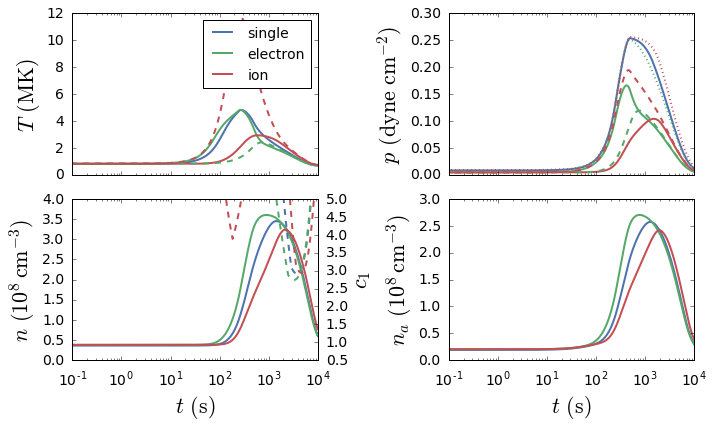

T_max (MK), single-fluid = 4.819484
T_max (MK), electron heating = 4.822435
n_max (MK), single-fluid = 0.345186
n_max (MK), electron heating = 0.360287


In [38]:
plot_results(cargill12_results['case1'])

### Case 2

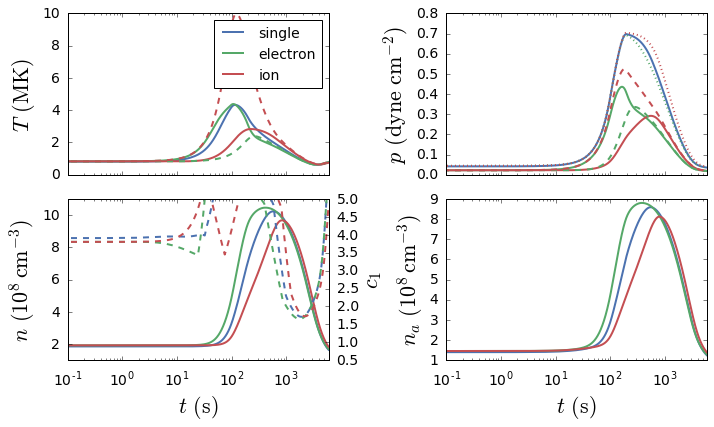

T_max (MK), single-fluid = 4.332897
T_max (MK), electron heating = 4.382899
n_max (MK), single-fluid = 1.023375
n_max (MK), electron heating = 1.046211


In [39]:
plot_results(cargill12_results['case2'])

### Case 3

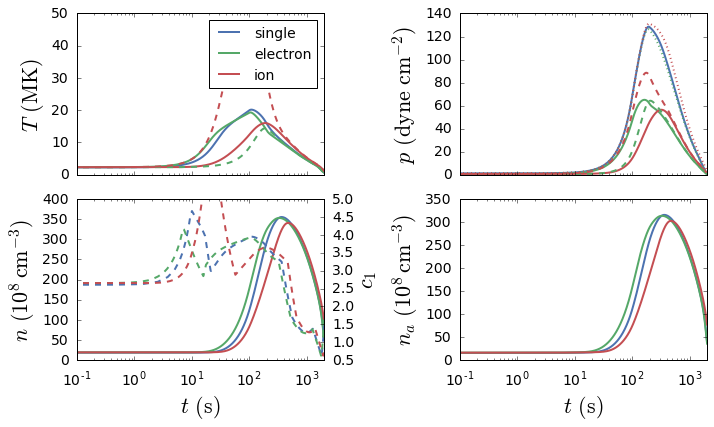

T_max (MK), single-fluid = 20.178640
T_max (MK), electron heating = 19.317150
n_max (MK), single-fluid = 35.527190
n_max (MK), electron heating = 35.290660


In [40]:
plot_results(cargill12_results['case3'])

### Case 4

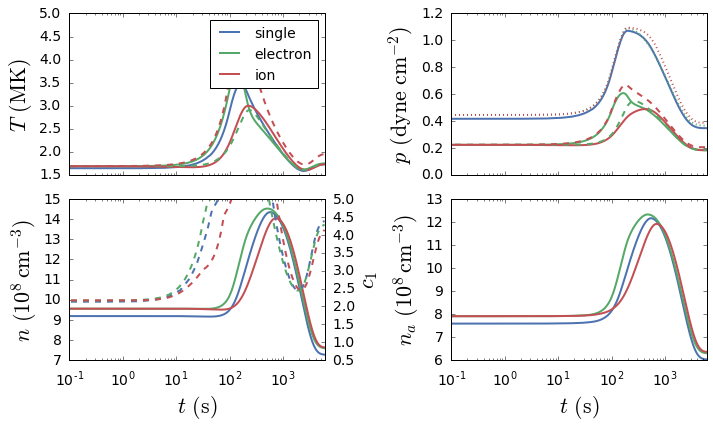

T_max (MK), single-fluid = 3.486475
T_max (MK), electron heating = 3.737982
n_max (MK), single-fluid = 1.434795
n_max (MK), electron heating = 1.452526


In [41]:
plot_results(cargill12_results['case4'])

### Comparison corrected $c_1$ runs and HYDRAD and EBTEL values as tabulated in Table 2 of Cargill et al. (2012a)

In the last two columns, I've assumed the original HYDRAD runs in this paper were done using the `force-single-fluid` option and so I've only included the single-fluid EBTEL results.

| Case | $T_{max}$ (MK), HYDRAD | $n_{max}$ ($10^9$ cm$^{-3}$), HYDRAD | $T_{max}$ (MK), EBTEL | $n_{max}$ ($10^9$ cm$^{-3}$), EBTEL | $T_{max}$ (MK), EBTEL, $c_1$ corrected | $n_{max}$ ($10^9$ cm$^{-3}$), EBTEL, $c_1$ corrected |
|:--------------:|:-------------:|:-----------:|:---------:|:---------:|:---------:|:--------:|
| 1 | 3.94| 0.37| 4.77| 0.39| 4.8| 0.34|
| 2 | 3.77| 1.07| 4.30| 1.15| 4.3| 1.02|
| 3 | 18.9| 33.9| 20.0| 38.7| 20.2| 35.5|
| 4 | 3.07| 1.55| 3.44| 1.64| 3.5| 1.4|

## Bradshaw & Cargill (2013)
Now look at some cases from Bradshaw & Cargill (2013) for more energetic nanoflares. 

| Case | $2L$ (Mm) | $E_H$ (erg cm$^{-3}$ s$^{-1}$) | $\tau_H$ (s) |
|:----:|:---------:|:------------------------------:|:------------:|
| 2 | 60 | 0.08 | 60 |
| 3 | 60 | 0.8 | 60 |
| 6 | 60 | 0.8 | 600 |
| 9 | 180 | 0.05 | 60 |
| 11 | 180 | 0.005 | 600 | 

In [42]:
run_dict_bc = {}
run_dict_bc['case2'] = {'total_time':2e3,'loop_length':20.0,'h_nano':0.08,'t_pulse_half':30.0,'h_back':3.19e-5}
run_dict_bc['case3'] = {'total_time':2e3,'loop_length':20.0,'h_nano':0.8,'t_pulse_half':30.0,'h_back':3.19e-5}
run_dict_bc['case6'] = {'total_time':2e3,'loop_length':20.0,'h_nano':0.8,'t_pulse_half':300.0,'h_back':3.19e-5}
run_dict_bc['case9'] = {'total_time':5e3,'loop_length':80.0,'h_nano':0.05,'t_pulse_half':30.0,'h_back':3.19e-5}
run_dict_bc['case11'] = {'total_time':5e3,'loop_length':80.0,'h_nano':0.005,'t_pulse_half':300.0,'h_back':3.19e-5}

In [43]:
bc13_results = {}
for key in run_dict_bc:
    bc13_results[key] = run_the_models(config_dict,run_dict_bc[key]['loop_length'],run_dict_bc[key]['h_nano'],
                                           run_dict_bc[key]['t_pulse_half'],run_dict_bc[key]['h_back'],run_dict_bc[key]['total_time'],
                                            configurer,runner_single_fluid,runner_two_fluid)

### Case 2

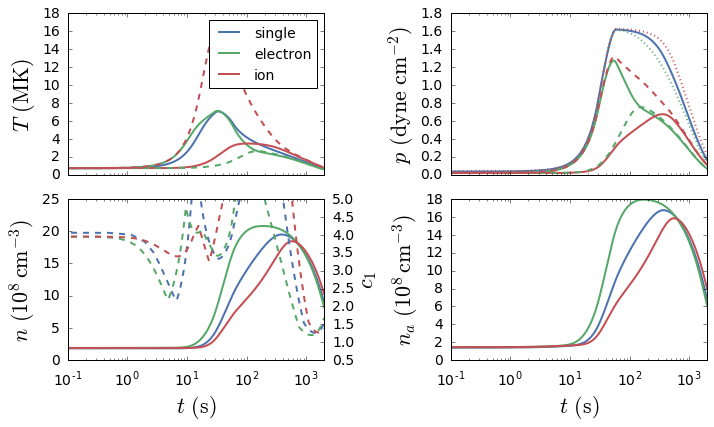

T_max (MK), single-fluid = 7.070571
T_max (MK), electron heating = 7.135324
n_max (MK), single-fluid = 1.949442
n_max (MK), electron heating = 2.081786


In [44]:
plot_results(bc13_results['case2'])

### Case 3

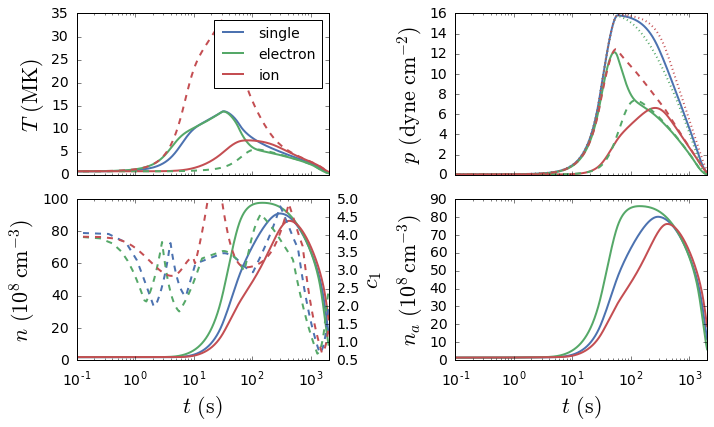

T_max (MK), single-fluid = 13.765780
T_max (MK), electron heating = 13.712820
n_max (MK), single-fluid = 9.100269
n_max (MK), electron heating = 9.764693


In [45]:
plot_results(bc13_results['case3'])

### Case 6

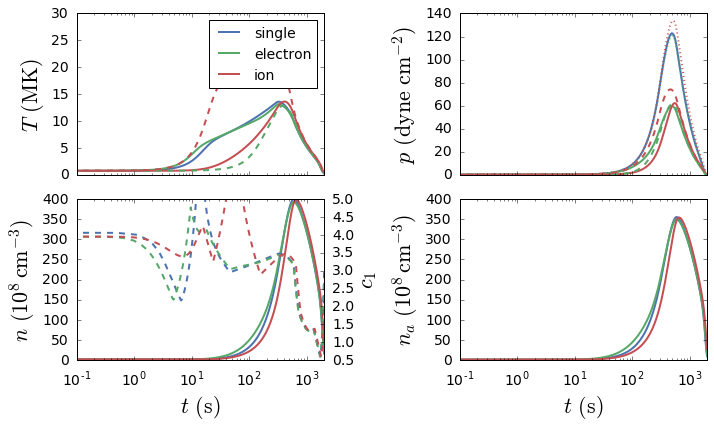

T_max (MK), single-fluid = 13.589260
T_max (MK), electron heating = 13.119070
n_max (MK), single-fluid = 39.907060
n_max (MK), electron heating = 39.229240


In [46]:
plot_results(bc13_results['case6'])

### Case 9

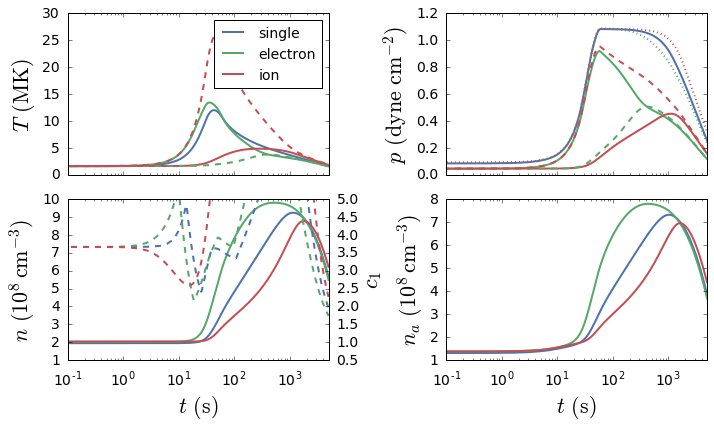

T_max (MK), single-fluid = 12.012680
T_max (MK), electron heating = 13.429960
n_max (MK), single-fluid = 0.923531
n_max (MK), electron heating = 0.979101


In [47]:
plot_results(bc13_results['case9'])

### Case 11

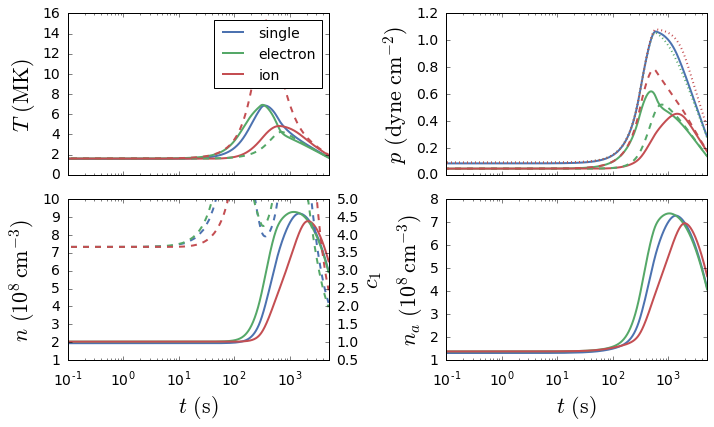

T_max (MK), single-fluid = 6.868649
T_max (MK), electron heating = 6.932541
n_max (MK), single-fluid = 0.918911
n_max (MK), electron heating = 0.927709


In [48]:
plot_results(bc13_results['case11'])

### Peter's Results: Single-fluid EBTEL runs as compared to HYDRAD
In the last two columns, the results shown in parentheses are the electron-heating results from the two-fluid EBTEL code.

|Group	| $2L$ (Mm) | $E_H$ (erg cm$^{-3}$ s$^{-1}$) | $\tau_H$ (s) | $T_m$ (MK), HYDRAD | $n_m$ ($10^9$), HYDRAD | $T_m$ (MK), EBTEL | $n_m$ ($10^9$), EBTEL | $T_m$ (MK), EBTEL, $c_1$ correction | $n_m$ ($10^9$), EBTEL, $c_1$ correction |
|:-----:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:----------:|:-------------:|
| 1 | 40 | 0.008 | 60 | 3 | 0.6 | 3.5 | 0.47 | | |
| 2 | 40 | 0.08 | 60 | 6.5 | 2 | 7 | 2.14 |	7.1 (7.1) | 1.95 (2.08) |
| 3 | 40 | 0.8 | 60 | 13 | 7 | 13 | 10 | 13.8 (13.7) | 9.10 (9.07) |
| 4 | 40 | 0.008 | 600 | 3.5 | 1.6 | 3.8 | 2.1 | | |	
| 5 | 40 | 0.08 | 600 | 7 | 8 | 7 | 9.84 |	| |
| 6 | 40 | 0.8 | 600 | 15 | 35 | 15 | 45.5 | 13.6 (13.1) | 39.9 (39.2) |
| 7 | 160 | 0.0005 | 60 | 2 | 0.3 | 1.5 | 0.1$^{***}$ |	| |
| 8 | 160 | 0.005 | 60 | 4 | 0.35 | 5 | 0.23$^{**}$ | | |
| 9 | 160 | 0.05 | 60 | 12 | 1 | 14 | 1 | 12.0 (13.4) | 0.92 (0.98) |
| 10 | 160 | 0.0005 | 600 | 3 | 0.3 | 3 | 0.23$^{**}$ | | |
| 11 | 160 | 0.005 | 600 | 6 | 1 | 7 | 1 | 6.9 (6.9) | 0.92 (0.93) |
| 12 | 160 | 0.05 | 600 | 13 | 4 | 13 | 4.6 | | |